#### Start

In [12]:
import pandas as pd
import numpy as np
import xarray as xr
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pyaldata import *
import pyaldata as pyal
from sklearn.decomposition import PCA, FactorAnalysis
# from ssa_functions_testversion2 import *
from sklearn.linear_model import Ridge, LinearRegression,RidgeCV
from canoncorr import *
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.stats import ortho_group
from scipy.linalg import orth
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression,RidgeCV,Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold,TimeSeriesSplit,RepeatedKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
import logging
import torch
import math
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from utils_communication import *
from decoders_m1_str import *
from RRR_final import ReducedRankRegressor


In [13]:
d = {'Shared - Reach': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0] , 'Unique - Reach ':[0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0] ,'Both - Reach ': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Shared - Grasp': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Unique - Grasp':[0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0], 'Both - Grasp': [0, 0 ,0 ,0, 0, 0, 0, 0 ,0 ,0 ,0, 0, 0 ,0 ,0 ,0 ,0, 0 ,0 ,0 ,0 ,0, 0, 0, 0 ,0 ,0]}
decod_df= pd.DataFrame(data=d)

In [14]:
diffs1=[];diffs2=[];diffs3=[]
diffs4=[];diffs5=[];diffs6=[]

In [15]:

for i in range(9):
    dataset= i+1

    if dataset==1:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat"
    elif dataset==2:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat"
    elif dataset==3:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat"
    # elif dataset==4:
    #     name="js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss.mat"
    elif dataset==4:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat"
    elif dataset==5:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat"
    elif dataset==6:
        name="js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat"
    
    #from here new datasests
    elif dataset==7:
        name="js2p0_tbytSpkHandJsTrjBin_WR37_022119_ss.mat"
    elif dataset==8:
        name="js2p0_tbytSpkHandJsTrjBin_WR37_022219_ss.mat"
    # elif dataset==10:
    #     name="js2p0_tbytSpkHandJsTrjBin_WR37_022619_ss.mat"
    # elif dataset==11:
        # name="js2p0_tbytSpkHandJsTrjBin_WR38_052319_ss.mat"
    elif dataset==9:
        name="js2p0_tbytSpkHandJsTrjBin_WR38_052119_ss"


    data_dir = "/Users/natal/Desktop/2021-2022/BE.NEURO/data"
    fname = os.path.join(data_dir, name) #original data is in matlab format
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)

    df_= prepro(df, dataset)

    if dataset<7:
        cols = ['hTrjB','hTrjBfull','hTrjBfullP1','rchSpeed1ms','jsXYbot']
    else:
        cols = ['hTrjB','hTrjBfull','hTrjBfullP1','rchSpeed1ms','jsXYbot','hXY_n_r','jXY_n_r','hXY_to_p1']

    df2 = df_.drop(cols, axis=1)

    ############## PCA ###################
    pca_m1_single, model_m1_single= dim_reduce(df2, PCA(15), "M1_rates", "M1_pca", return_model = True) 
    pca_str_single, model_str_single= dim_reduce(df2, PCA(15), "Str_rates", "Str_pca", return_model = True) 


    ############# RRR ######################
    X= np.concatenate(pca_m1_single['M1_pca'])
    Y= np.concatenate(pca_str_single['Str_pca'])

    obj= ReducedRankRegressor(rank=9, reg=None)
    dim_fit= obj.fit(X, Y)
    shared_dimensions= obj.predict(X)


    m= np.dot(np.dot(X,np.linalg.inv(np.dot(X.T,X))),X.T)

    proj= np.dot(m,shared_dimensions)

    unique_dimensions= X-proj

    ############ PREPRO DECODER

    pc_reach_shared_pos, pc_reach_unique_pos,pos_reach= prepro_decoder_communication_reaching(df2,shared_dimensions, unique_dimensions, 'position', 15)
    pc_grasp_shared_pos, pc_grasp_unique_pos,pos_grasp= prepro_decoder_communication_grasping(df2,shared_dimensions, unique_dimensions, 'position', 15)


    ############ HISTORY
    for k in range(3):
        pc_reach_shared_pos, pc_reach_unique_pos,pos_reach1= add_history(10,pc_reach_shared_pos,pc_reach_unique_pos,pos_reach,k)
        pc_grasp_shared_pos, pc_grasp_unique_pos,pos_grasp1= add_history(10,pc_grasp_shared_pos,pc_grasp_unique_pos,pos_grasp,k)

        pos_reach= pos_reach[10:,:]
        pos_grasp= pos_grasp[10:,:]

        v1, pr1= RidgeCV_decoder(pc_reach_shared_pos,pos_reach[:,k].reshape(-1,1))
        v2, pr2= RidgeCV_decoder(pc_reach_unique_pos,pos_reach[:,k].reshape(-1,1))
        v3, pr3= RidgeCV_decoder(np.concatenate((pc_reach_shared_pos,pc_reach_unique_pos),axis=1),pos_reach[:,k].reshape(-1,1))

        v4, pr4= RidgeCV_decoder(pc_grasp_shared_pos,pos_grasp[:,k].reshape(-1,1))
        v5, pr5= RidgeCV_decoder(pc_grasp_unique_pos,pos_grasp[:,k].reshape(-1,1))
        v6, pr6= RidgeCV_decoder(np.concatenate((pc_grasp_shared_pos,pc_grasp_unique_pos),axis=1),pos_grasp[:,k].reshape(-1,1))

        if k==0:
            decod_df.iloc[i,0]=v1
            decod_df.iloc[i,1]=v2
            decod_df.iloc[i,2]=v3
            decod_df.iloc[i,3]=v4
            decod_df.iloc[i,4]=v5
            decod_df.iloc[i,5]=v6
        elif k==1:
            decod_df.iloc[i+9,0]=v1
            decod_df.iloc[i+9,1]=v2
            decod_df.iloc[i+9,2]=v3
            decod_df.iloc[i+9,3]=v4
            decod_df.iloc[i+9,4]=v5
            decod_df.iloc[i+9,5]=v6

        else:
            decod_df.iloc[i+18,0]=v1
            decod_df.iloc[i+18,1]=v2
            decod_df.iloc[i+18,2]=v3
            decod_df.iloc[i+18,3]=v4
            decod_df.iloc[i+18,4]=v5
            decod_df.iloc[i+18,5]=v6

        fig, ax = plt.subplots(6,1,figsize=(10,25))
        diff1= pr1-pos_reach[:,k].reshape(-1,1); diffs1.append(diff1)
        diff2= pr2-pos_reach[:,k].reshape(-1,1); diffs2.append(diff2)
        diff3= pr3-pos_reach[:,k].reshape(-1,1); diffs3.append(diff3)
        diff4= pr4-pos_grasp[:,k].reshape(-1,1); diffs4.append(diff4)
        diff5= pr5-pos_grasp[:,k].reshape(-1,1); diffs5.append(diff5)
        diff6= pr6-pos_grasp[:,k].reshape(-1,1); diffs6.append(diff6)
    
        ax[0].plot(diff1); ax[0].set_title('Shared Dims Reaching')
        ax[1].plot(diff2);ax[1].set_title('Shared Dims Reaching')
        ax[2].plot(diff3);ax[2].set_title('Shared Dims Reaching')
        ax[3].plot(diff4);ax[3].set_title('Shared Dims Reaching')
        ax[4].plot(diff5);ax[4].set_title('Shared Dims Reaching')
        ax[5].plot(diff6);ax[5].set_title('Shared Dims Reaching') 
        fig.savefig(f'differences_trial{i}_{k}.png')

        


field unitTimeBCtx could not be converted to int.
field unitTimeBStr could not be converted to int.


In [7]:
decod_df

,Shared - Reach,Unique - Reach,Both - Reach,Shared - Grasp,Unique - Grasp,Both - Grasp
0,0.352856,0.476122,0.525594,0.422770,0.456784,0.543757
1,0.303411,0.500566,0.554874,0.692118,0.738939,0.812657
2,0.638457,0.690113,0.725916,0.688775,0.783314,0.831523
3,0.726629,0.708638,0.756701,0.636809,0.770464,0.800157
4,0.808400,0.873302,0.895587,0.875846,0.921402,0.943095
5,0.588069,0.685454,0.728025,0.473634,0.620174,0.665927
6,0.270191,0.314053,0.344109,0.532362,0.620419,0.653065
7,0.234389,0.329827,0.357882,0.680798,0.743026,0.785646
8,0.269653,0.313818,0.343705,0.537988,0.619698,0.652850
9,0.681889,0.830672,0.875218,0.654894,0.794582,0.870461


In [8]:
decod_df.to_csv('comm_pos_m1_str.csv')

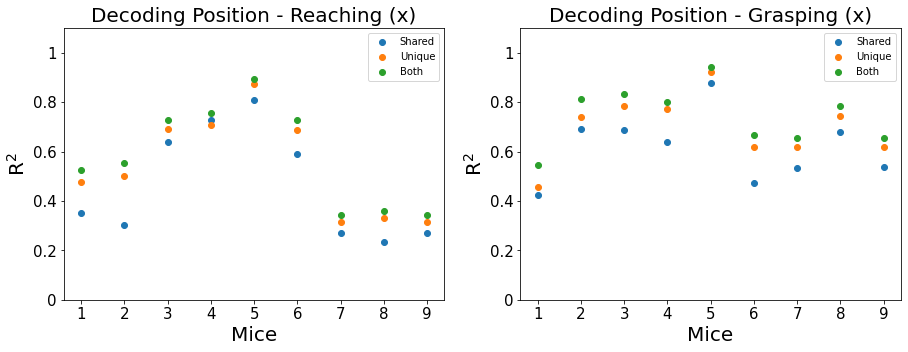

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (x)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[:8,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (x)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)






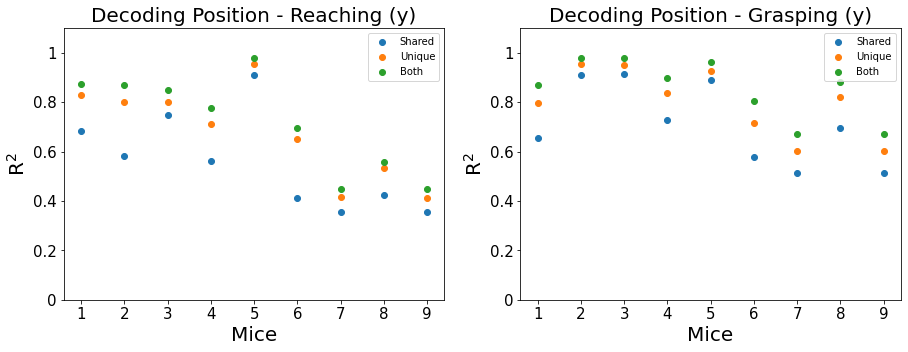

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (y)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[9:17,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (y)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)






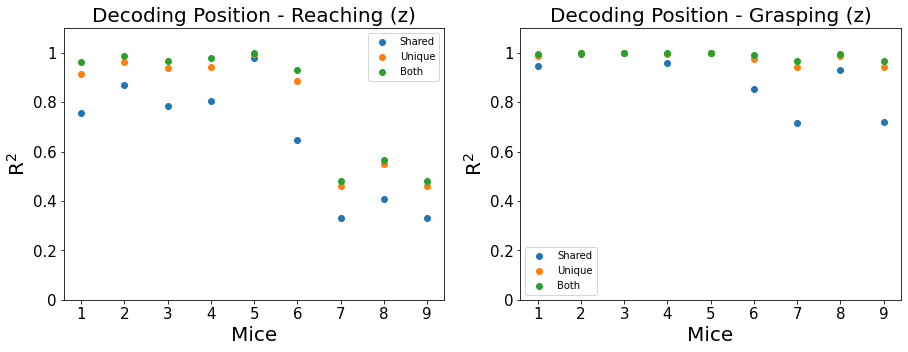

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Shared - Reach']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Unique - Reach ']))
ax[0].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Both - Reach ']))

ax[0].set_xlabel('Mice',fontsize=20)
ax[0].set_ylabel('R$^2$',fontsize=20)
ax[0].set_ylim(0,1.1)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9])
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[0].set_title('Decoding Position - Reaching (z)',fontsize=20)
ax[0].legend(['Shared','Unique', 'Both'],fontsize=10)



ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Shared - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Unique - Grasp']))
ax[1].scatter([1,2,3,4,5,6,7,8,9],np.array(decod_df.loc[18:,'Both - Grasp']))

ax[1].set_xlabel('Mice',fontsize=20)
ax[1].set_ylabel('R$^2$',fontsize=20)
ax[1].set_ylim(0,1.1)

ax[1].set_xticks([1,2,3,4,5,6,7,8,9])
ax[1].set_xticklabels([1,2,3,4,5,6,7,8,9],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1])
ax[1].set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=15)

ax[1].set_title('Decoding Position - Grasping (z)',fontsize=20)
ax[1].legend(['Shared','Unique', 'Both'],fontsize=10)

